# Detecto Demo

Thanks for checking out [Detecto](https://github.com/alankbi/detecto)! To work alongside this tutorial, follow the following steps:

*   Create a new Drive folder
*   Copy this Colab notebook into your folder
*   Check that the GPU is enabled (Edit -> Notebook settings)
*   Download the demo dataset [here](https://github.com/alankbi/detecto/blob/master/docs/_static/dog_dataset.zip) (*) and upload the unzipped contents to your folder

Make sure your notebook has the GPU enabled: Edit -> Notebook settings

In our dataset, we have about 300 labeled images of Chihuahuas and Golden Retrievers. We'll train an object detection model to distinguish between the two. 

** This dataset is a modified subset of the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/).* 

First, mount your drive to give the notebook access to your Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Next, change directory to wherever you created your folder. 

In [2]:
import os

# TODO: Change this to your Drive folder location
WORKING_DIRECTORY = '/content/drive/My Drive/TensorFlow'

os.chdir(WORKING_DIRECTORY)

In [3]:
# List the contents of your working directory
# It should contain at least three folders: images, train_labels, and val_labels
!ls

Img_Aug   test_labels.csv  train_aug	  train.csv	    train_xml
test	  test_xml	   train_aug_img  train_img	    val.csv
test_img  train		   train_aug_xml  train_labels.csv


Now, let's install the Detecto package using pip. 

In [4]:
# Note: if it states you must restart the runtime in order to use a
# newly installed version of a package, you do NOT need to do this. 
!pip install detecto

Import everything we need in the following code block:

In [5]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torchvision import transforms
from detecto import core, utils, visualize

To check that everything's working, we can try reading in one of the images from our images folder. 

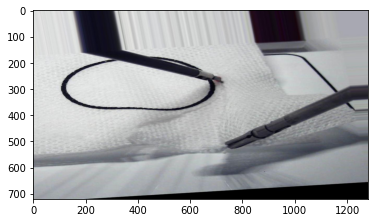

In [6]:
image = utils.read_image('/content/drive/My Drive/TensorFlow/Img_Aug/A12.jpg')
plt.imshow(image)
plt.show()

How cute! Now, we're ready to create our dataset and train our model. However, before doing so, it's a bit slow working with hundreds of individual XML label files, so we should convert them into a single CSV file to save time later down the line. 

Training Part

In [7]:
from detecto import core

# All images and XML files in the same folder
dataset = core.Dataset('/content/drive/My Drive/TensorFlow/train')

# Images and XML files in separate folders
dataset = core.Dataset('/content/drive/My Drive/TensorFlow/train_xml', '/content/drive/My Drive/TensorFlow/train_img')
print(len(dataset))
image, target = dataset[0]
print(image, target)

398
tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-0.3541, -0.3198, -0.3027,  ..., -0.0287, -0.0287, -0.0287],
         [-0.7993, -0.7993, -0.8164,  ..., -0.5938, -0.5938, -0.5938],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-0.2325, -0.1975, -0.1800,  ...,  0.1176,  0.1176,  0.1176],
         [-0.6702, -0.6702, -0.6877,  ..., -0.4601, -0.4601, -0.4601],
         [-2.0182, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ...

In [8]:
# Do this twice: once for our training labels and once for our validation labels
utils.xml_to_csv('/content/drive/My Drive/TensorFlow/train_xml', 'train.csv')
utils.xml_to_csv('/content/drive/My Drive/TensorFlow/test_xml', 'val.csv')

,filename,width,height,class,xmin,ymin,xmax,ymax
0,Slide8.JPG,1280,720,Scissor,464,176,522,227
1,Slide8.JPG,1280,720,Grasper,242,314,358,536
2,Slide8.JPG,1280,720,Circle,356,91,757,345
3,Slide9.JPG,1280,720,Scissor,327,42,409,103
4,Slide9.JPG,1280,720,Grasper,358,118,443,190
...,...,...,...,...,...,...,...,...
168,E78.jpg,1280,720,Grasper,713,325,778,424
169,E78.jpg,1280,720,Circle,779,230,1076,471
170,E75.jpg,1280,720,Scissor,882,299,1013,367
171,E75.jpg,1280,720,Grasper,884,361,1022,422


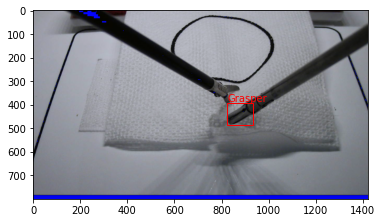

In [9]:
# Specify a list of transformations for our dataset to apply on our images
transform_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(800),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    utils.normalize_transform(),
])

dataset = core.Dataset('train.csv', '/content/drive/My Drive/TensorFlow/train_img', transform=transform_img)

# dataset[i] returns a tuple containing our transformed image and
# and a dictionary containing label and box data
image, target = dataset[35]
visualize.show_labeled_image(image, target['boxes'], target['labels'])

In [10]:
model = core.Model(['Grasper', 'Scissor', 'Circle'])

In [12]:
model.fit(dataset)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [16]:
model.save('/content/drive/My Drive/TensorFlow/saved_model.pth')

In [17]:
# Specify the path to your image
image = utils.read_image('/content/drive/My Drive/TensorFlow/test_img/Slide30.JPG')
predictions = model.predict(image)

# predictions format: (labels, boxes, scores)
labels, boxes, scores = predictions

# ['Grasper', 'Scissor', 'Circle']
Label = labels
print(labels) 


#           xmin       ymin       xmax       ymax
# tensor([[ 569.2125,  203.6702, 1003.4383,  658.1044],
#         [ 276.2478,  144.0074,  579.6044,  508.7444],
#         [ 277.2929,  162.6719,  627.9399,  511.9841]])
print(boxes)


# tensor([0.9952, 0.9837, 0.5153])
Score=scores
print(scores) 

['Circle', 'Scissor', 'Grasper']
tensor([[357.7988,  57.3787, 742.3510, 340.4494],
        [808.4847, 307.3540, 893.2709, 396.0181],
        [459.2028, 428.0353, 550.1653, 511.7645]])
tensor([0.8181, 0.7901, 0.7626])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [18]:
 if len(Label) > 3:
          Label = [Label[0], Label[1], Label[2]]
          print(Label)
          Score = [Score[0], Score[1], Score[2]]
          print(Score)
 else:
      Label = Label
      Score = Score
      print(Label)
      print(Score)

['Circle', 'Scissor', 'Grasper']
tensor([0.8181, 0.7901, 0.7626])


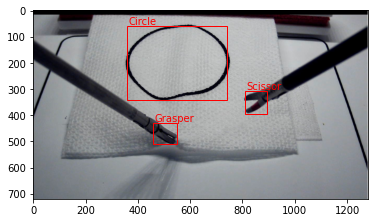

In [19]:
visualize.show_labeled_image(image, boxes[:3, :], labels)

In [21]:
from torchvision import transforms

augmentations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(saturation=0.5),
    transforms.ToTensor(),
    utils.normalize_transform(),
])

dataset = core.Dataset('/content/drive/My Drive/TensorFlow/train', transform=augmentations)

loader = core.DataLoader(dataset, batch_size=2, shuffle=True)

Epoch 1 of 35


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Loss: 0.13171508654176844
Epoch 2 of 35
Loss: 0.10984470805077884
Epoch 3 of 35
Loss: 0.10909286090791914
Epoch 4 of 35
Loss: 0.10866616145207014
Epoch 5 of 35
Loss: 0.09748549604346987
Epoch 6 of 35
Loss: 0.09859483527568723
Epoch 7 of 35
Loss: 0.0998439071861478
Epoch 8 of 35
Loss: 0.10140981061136448
Epoch 9 of 35
Loss: 0.10294550247059736
Epoch 10 of 35
Loss: 0.10202333341874828
Epoch 11 of 35
Loss: 0.1032330485631448
Epoch 12 of 35
Loss: 0.10295464472059225
Epoch 13 of 35
Loss: 0.10263581385545303
Epoch 14 of 35
Loss: 0.1022257595995947
Epoch 15 of 35
Loss: 0.10127015600271652
Epoch 16 of 35
Loss: 0.10273404521706132
Epoch 17 of 35
Loss: 0.10238097346457788
Epoch 18 of 35
Loss: 0.10219744604748453
Epoch 19 of 35
Loss: 0.10116749927616878
Epoch 20 of 35
Loss: 0.10215274513715264
Epoch 21 of 35
Loss: 0.10216523830730447
Epoch 22 of 35
Loss: 0.10157154575851611
Epoch 23 of 35
Loss: 0.10125336408442845
Epoch 24 of 35
Loss: 0.1019756374611503
Epoch 25 of 35
Loss: 0.10122054736695194
Ep

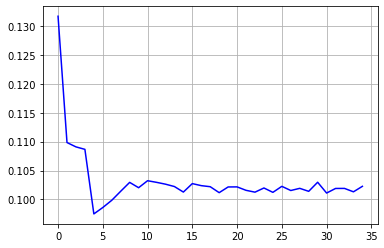

In [22]:
import matplotlib.pyplot as plt

val_dataset = core.Dataset('/content/drive/My Drive/TensorFlow/test')

losses = model.fit(loader, val_dataset, epochs=35, learning_rate=0.01, 
                   lr_step_size=5, verbose=True)
Score=scores
print(scores) 
                   
plt.plot(losses, '-b', label='train')
plt.grid(True)
plt.show()

In [23]:
Score=scores
print(scores) 

tensor([0.8181, 0.7901, 0.7626])


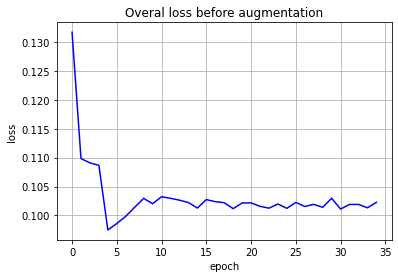

In [24]:
plt.plot(losses, '-b', label='train') # before aug
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.title('Overal loss before augmentation');
plt.show()

Evaluation Part

In [25]:
# Do this twice: once for our training labels and once for our validation labels
utils.xml_to_csv('/content/drive/My Drive/TensorFlow/train_aug_xml', 'train_aug.csv')
utils.xml_to_csv('/content/drive/My Drive/TensorFlow/test_xml', 'val.csv')

,filename,width,height,class,xmin,ymin,xmax,ymax
0,Slide8.JPG,1280,720,Scissor,464,176,522,227
1,Slide8.JPG,1280,720,Grasper,242,314,358,536
2,Slide8.JPG,1280,720,Circle,356,91,757,345
3,Slide9.JPG,1280,720,Scissor,327,42,409,103
4,Slide9.JPG,1280,720,Grasper,358,118,443,190
...,...,...,...,...,...,...,...,...
168,E78.jpg,1280,720,Grasper,713,325,778,424
169,E78.jpg,1280,720,Circle,779,230,1076,471
170,E75.jpg,1280,720,Scissor,882,299,1013,367
171,E75.jpg,1280,720,Grasper,884,361,1022,422


Below, we create our dataset, applying a couple of transforms beforehand. These are optional, but they can be useful for augmenting your dataset without gathering more data. 

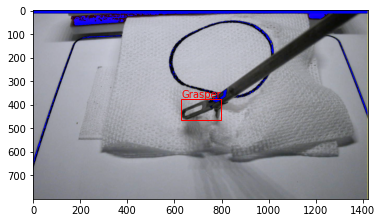

In [28]:
# Specify a list of transformations for our dataset to apply on our images
transform_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(800),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    utils.normalize_transform(),
])

dataset1 = core.Dataset('train_aug.csv', '/content/drive/My Drive/TensorFlow/train_aug_img', transform=transform_img)

# dataset[i] returns a tuple containing our transformed image and
# and a dictionary containing label and box data
image, target = dataset[20]

# Show our image along with the box. Note: it may
# be colored oddly due to being normalized by the 
# dataset and then reverse-normalized for plotting
visualize.show_labeled_image(image, target['boxes'], target['labels'])

Finally, let's train our model! First, we create a DataLoader over our dataset to specify how we feed the images into our model. We also use our validation dataset to track the accuracy of the model throughout training. 

Epoch 1 of 35


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Loss: 0.15583911408923265
Epoch 2 of 35
Loss: 0.1310993062192305
Epoch 3 of 35
Loss: 0.10519966772741321
Epoch 4 of 35
Loss: 0.09982660934975036
Epoch 5 of 35
Loss: 0.10035961272055013
Epoch 6 of 35
Loss: 0.0874118600579011
Epoch 7 of 35
Loss: 0.08398344964219656
Epoch 8 of 35
Loss: 0.08185050276920974
Epoch 9 of 35
Loss: 0.08059666961474571
Epoch 10 of 35
Loss: 0.07908153957068231
Epoch 11 of 35
Loss: 0.07785400879607035
Epoch 12 of 35
Loss: 0.07859587652145783
Epoch 13 of 35
Loss: 0.07780194548470092
Epoch 14 of 35
Loss: 0.07890086431551531
Epoch 15 of 35
Loss: 0.07681327990412368
Epoch 16 of 35
Loss: 0.07842770845473157
Epoch 17 of 35
Loss: 0.07838102493628946
Epoch 18 of 35
Loss: 0.07793593858880114
Epoch 19 of 35
Loss: 0.07808735889161943
Epoch 20 of 35
Loss: 0.0782680735530364
Epoch 21 of 35
Loss: 0.07818968730811783
Epoch 22 of 35
Loss: 0.07917562244470754
Epoch 23 of 35
Loss: 0.07797789284044263
Epoch 24 of 35
Loss: 0.07770737777383341
Epoch 25 of 35
Loss: 0.0773679746282583
Ep

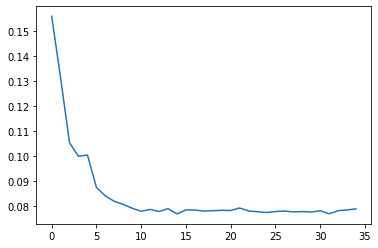

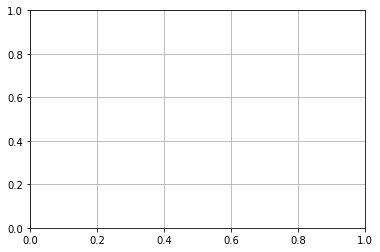

In [29]:
# Create our validation dataset
val_dataset = core.Dataset('val.csv', '/content/drive/My Drive/TensorFlow/test_img')

# Create the loader for our training dataset
loader = core.DataLoader(dataset1, batch_size=2, shuffle=True)

# Create our model, passing in all unique classes we're predicting
# Note: make sure these match exactly with the labels in the XML/CSV files!
model = core.Model(['Grasper', 'Scissor', 'Circle'])

# Train the model! This step can take a while, so make sure you
# the GPU is turned on in Edit -> Notebook settings
losses1 = model.fit(loader, val_dataset, epochs=35, learning_rate=0.01, 
                   lr_step_size=5,verbose=True)

Score=scores
print(scores) 
# Plot the accuracy over time
plt.plot(losses1)
plt.show()
plt.grid(True)

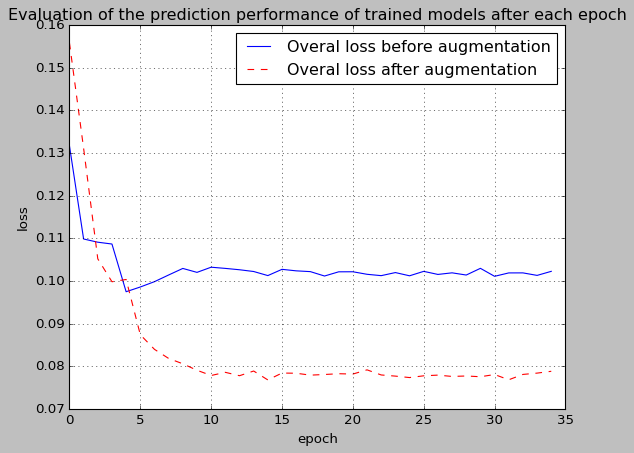

In [38]:

plt.plot(losses, '-b', label='Overal loss before augmentation') # before aug
plt.plot(losses1, '--r', label='Overal loss after augmentation') # after aug
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.title('Evaluation of the prediction performance of trained models after each epoch')


plt.legend();

plt.show()

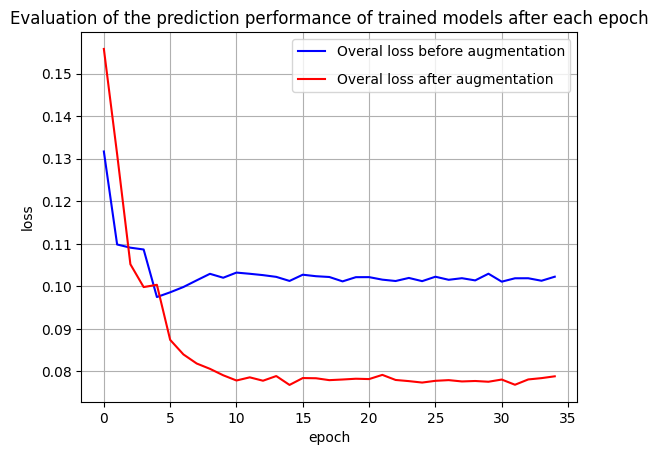

In [53]:

plt.plot(losses, '-b', label='Overal loss before augmentation') # before aug
plt.plot(losses1, '-r', label='Overal loss after augmentation') # after aug
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.title('Evaluation of the prediction performance of trained models after each epoch')

plt.style.use('default')
plt.legend();
plt.legend(scatterpoints=1, frameon=True, labelspacing=1)
plt.show()

Let's see how well our model does on a couple images from our validation set:

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


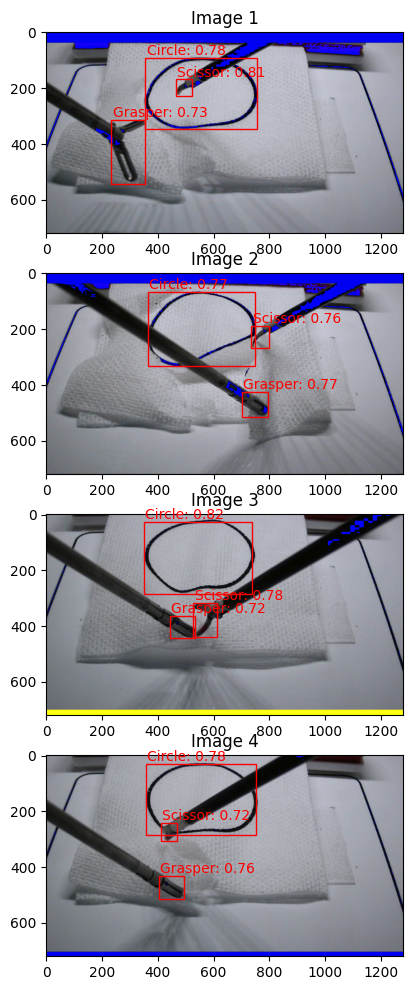

In [75]:
images = []
# Create a list of images 0, 5, 10, ... 40 from val_dataset
for i in range(0, 32,8):
    image, _ = val_dataset[i]
    images.append(image)

# Plot a 3x3 grid of the model's predictions on our 9 images
visualize.plot_prediction_grid(model, images, dim=(4, 1), figsize=(16, 12))



Overall, the model works as expected; in most of the images, it outputs high confidence values for the correct breed of dog shown. With a bit more fine-tuning, we could make it even better!

Video

In [79]:
from detecto.core import Model
from detecto.visualize import detect_video

model = Model(['Grasper', 'Scissor', 'Circle'])  # Initialize a pre-trained model
detect_video(model, '/content/drive/My Drive/Box_Trainer.mp4', 'output.avi', score_filter = 0.67)  # Run inference on a video

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [ ]:
/content/output.avi

## Conclusion

Thanks for making it this far through the demo!

This is as far as the demo goes, but a great next step would be seeing how well the model works on a live video of Chihuahuas and Golden Retrievers in the same frame at the same time. To learn more about Detecto, be sure to check out the [Quickstart guide](https://detecto.readthedocs.io/en/latest/usage/quickstart.html), [Further Usage guide](https://detecto.readthedocs.io/en/latest/usage/further-usage.html), and [API docs](https://detecto.readthedocs.io/en/latest/api.html)!